# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

Had to install to make these modules work locally

In [225]:
!pip install -U torch
!pip install -U transformers

In [177]:
!pip install -U spacy
!pip install -U lightgbm 
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [252]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import spacy

from tqdm.auto import tqdm

In [253]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [254]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [255]:
df_reviews = pd.read_csv('./imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [256]:
df_reviews.tconst.value_counts()

tt0070337    30
tt0071075    30
tt0377818    30
tt0051418    30
tt0429177    30
             ..
tt0041238     1
tt0065025     1
tt0144714     1
tt0757046     1
tt0847830     1
Name: tconst, Length: 6648, dtype: int64

In [257]:
df_reviews.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### Handeling Duplicates

In [258]:
df_reviews[df_reviews['review'].duplicated()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1370,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301,0,"Drama,Romance,War",8.3,849,I have seen this film at least 100 times and I...,10,pos,1,test,9768
1630,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114,0,"Crime,Drama,Mystery",6.6,3098,THE JIST: See something else. This film was hi...,7,pos,1,train,7729
1983,tt0115509,movie,All Dogs Go to Heaven 2,All Dogs Go to Heaven 2,1996,\N,82,0,"Adventure,Animation,Family",5.5,5396,This movie is very scary with scenes where the...,1,neg,0,test,7914
2132,tt0092545,movie,Amazing Grace and Chuck,Amazing Grace and Chuck,1987,\N,114,0,"Drama,Sport",6.0,1235,I saw this in the summer of 1990. I'm still an...,1,neg,0,train,6320
2236,tt0181288,movie,American Movie,American Movie,1999,\N,107,0,"Comedy,Documentary",7.9,16416,This is an Emperor's New Clothes situation. So...,1,neg,0,test,1470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46064,tt0038245,movie,Where Do We Go from Here?,Where Do We Go from Here?,1945,\N,74,0,"Fantasy,Musical",5.8,220,"During a Kurt Weill celebration in Brooklyn, W...",8,pos,1,train,4267
47052,tt0365960,movie,Zero Day,Zero Day,2002,\N,92,0,Drama,7.2,3947,Everyone knows about this ''Zero Day'' event. ...,10,pos,1,train,11470
47194,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81,0,Horror,2.0,7850,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10108
47290,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5655


Very small number 91 out of 47000, we will drop these rows.

In [259]:
df_dup = df_reviews[df_reviews['review'].duplicated()]

In [260]:
df_reviews = df_reviews.drop(df_dup.index)

In [261]:
df_reviews.shape

(47240, 17)

In [262]:
df_reviews.primary_title.value_counts()

The Sentinel                 60
The War at Home              54
Emma                         51
Jane Eyre                    49
In Cold Blood                42
                             ..
The Milky Way                 1
Disorderly Conduct            1
Agata and the Storm           1
Half-Life: Counter-Strike     1
Lady in the Box               1
Name: primary_title, Length: 6555, dtype: int64

### Handeling NA values

In [263]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Insignificant number so we will drop these rows

In [264]:
df_reviews.dropna(inplace=True)

In [265]:
df_reviews.shape

(47238, 17)

### Handeling abnormal values

In [266]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47238.000000,47238.000000,47238.000000,4.723800e+04,47238.000000,47238.000000,47238.000000
mean,1989.626466,0.001736,5.998421,2.559903e+04,5.482472,0.498709,6280.074707
std,19.607380,0.041628,1.494312,8.374446e+04,3.472692,0.500004,3605.566089
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.250000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9413.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


We see start year has some strange values, but after reading the reviews these are legitimate films

## EDA

Let's check the number of movies and reviews over years.

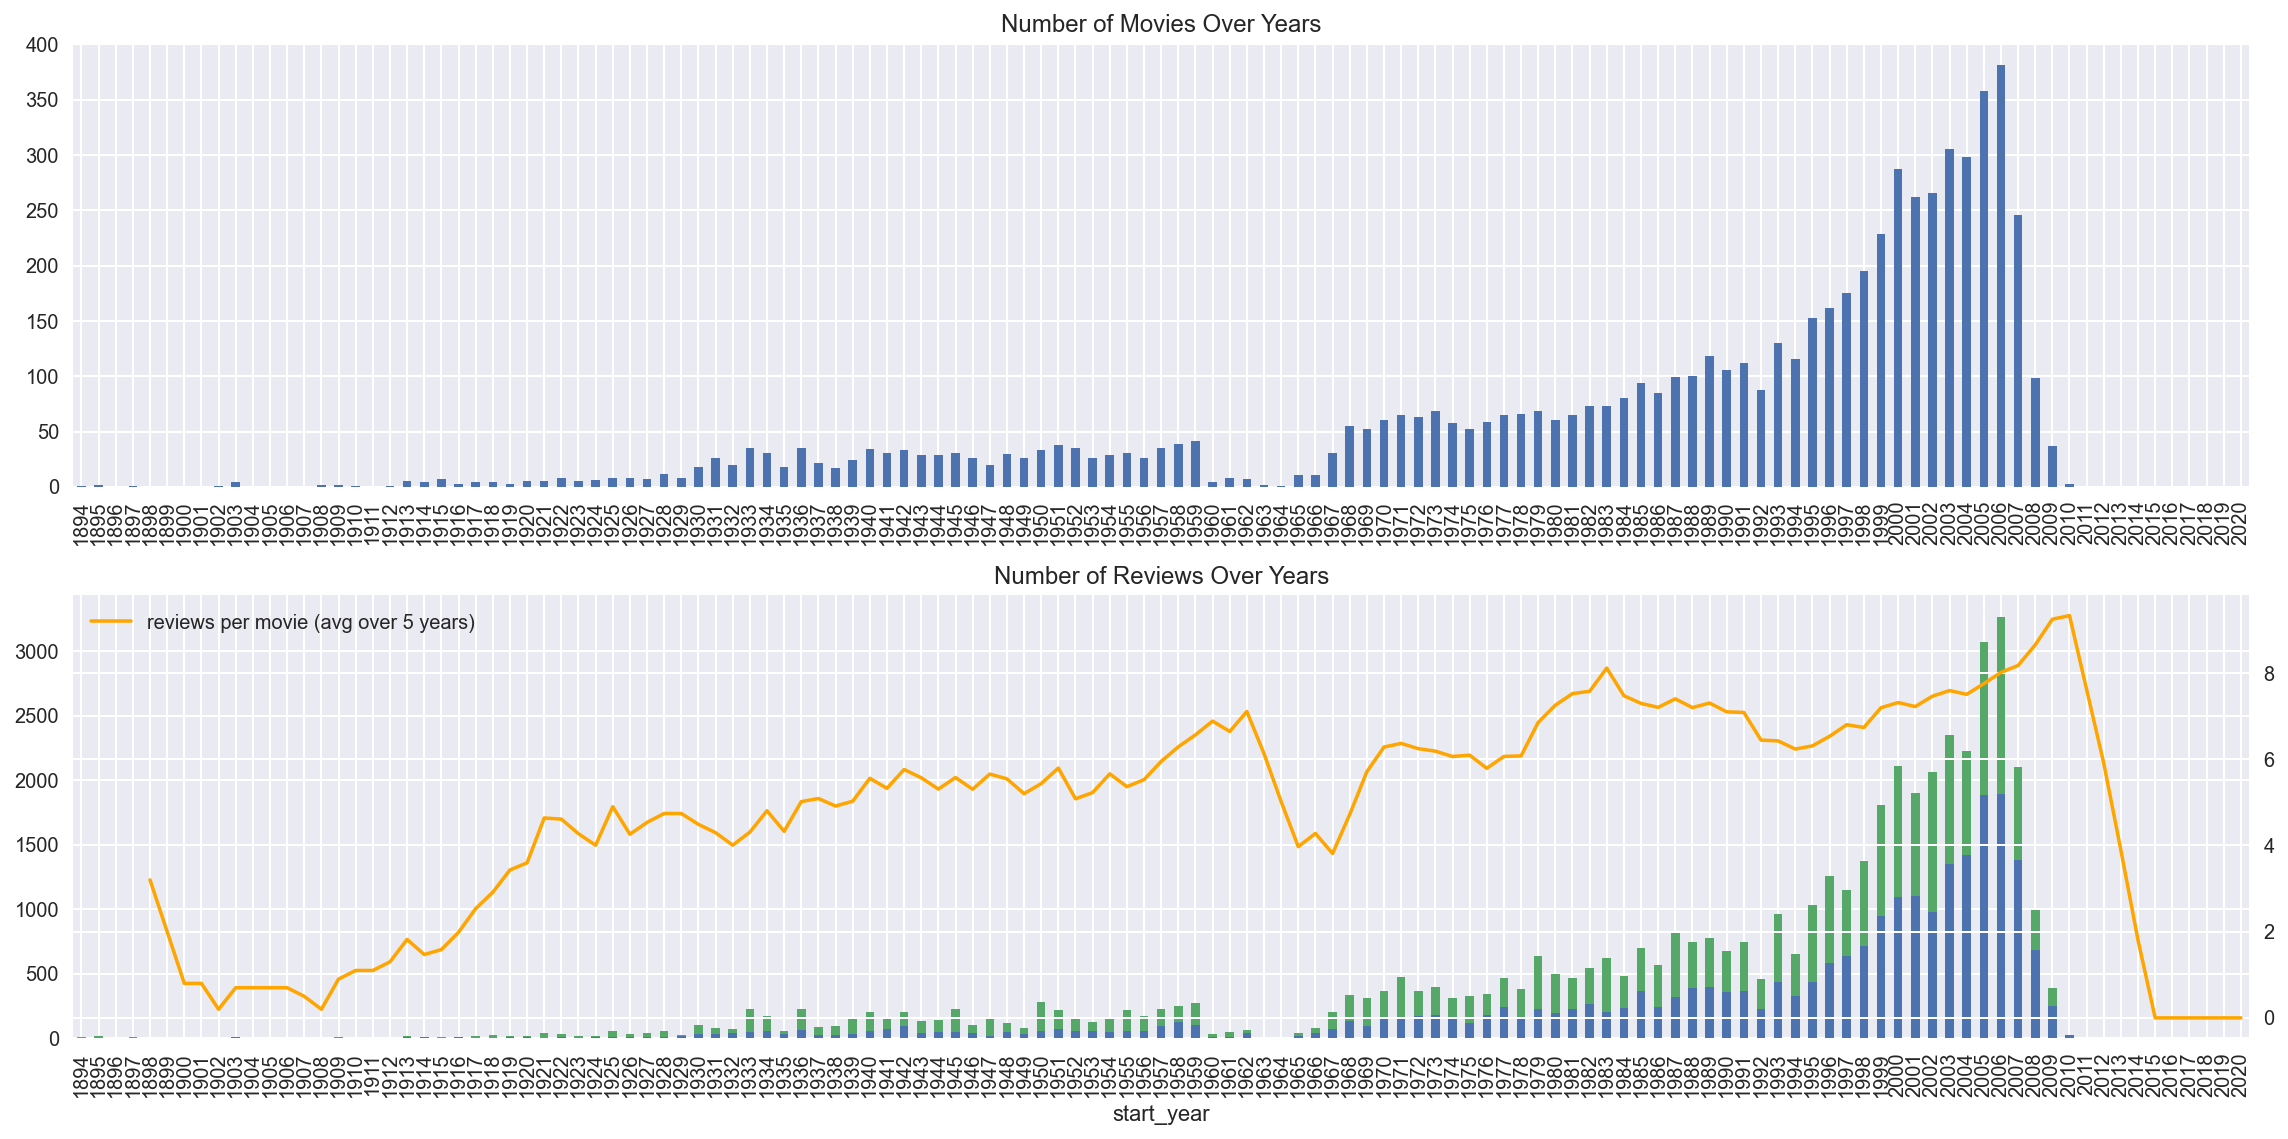

In [267]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We see as the year progressed we hve more and more movies, we see a couple of drops.

The last drop is because we don't have data on those years.

We can also see the number of positive review vs negative reviews are close.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

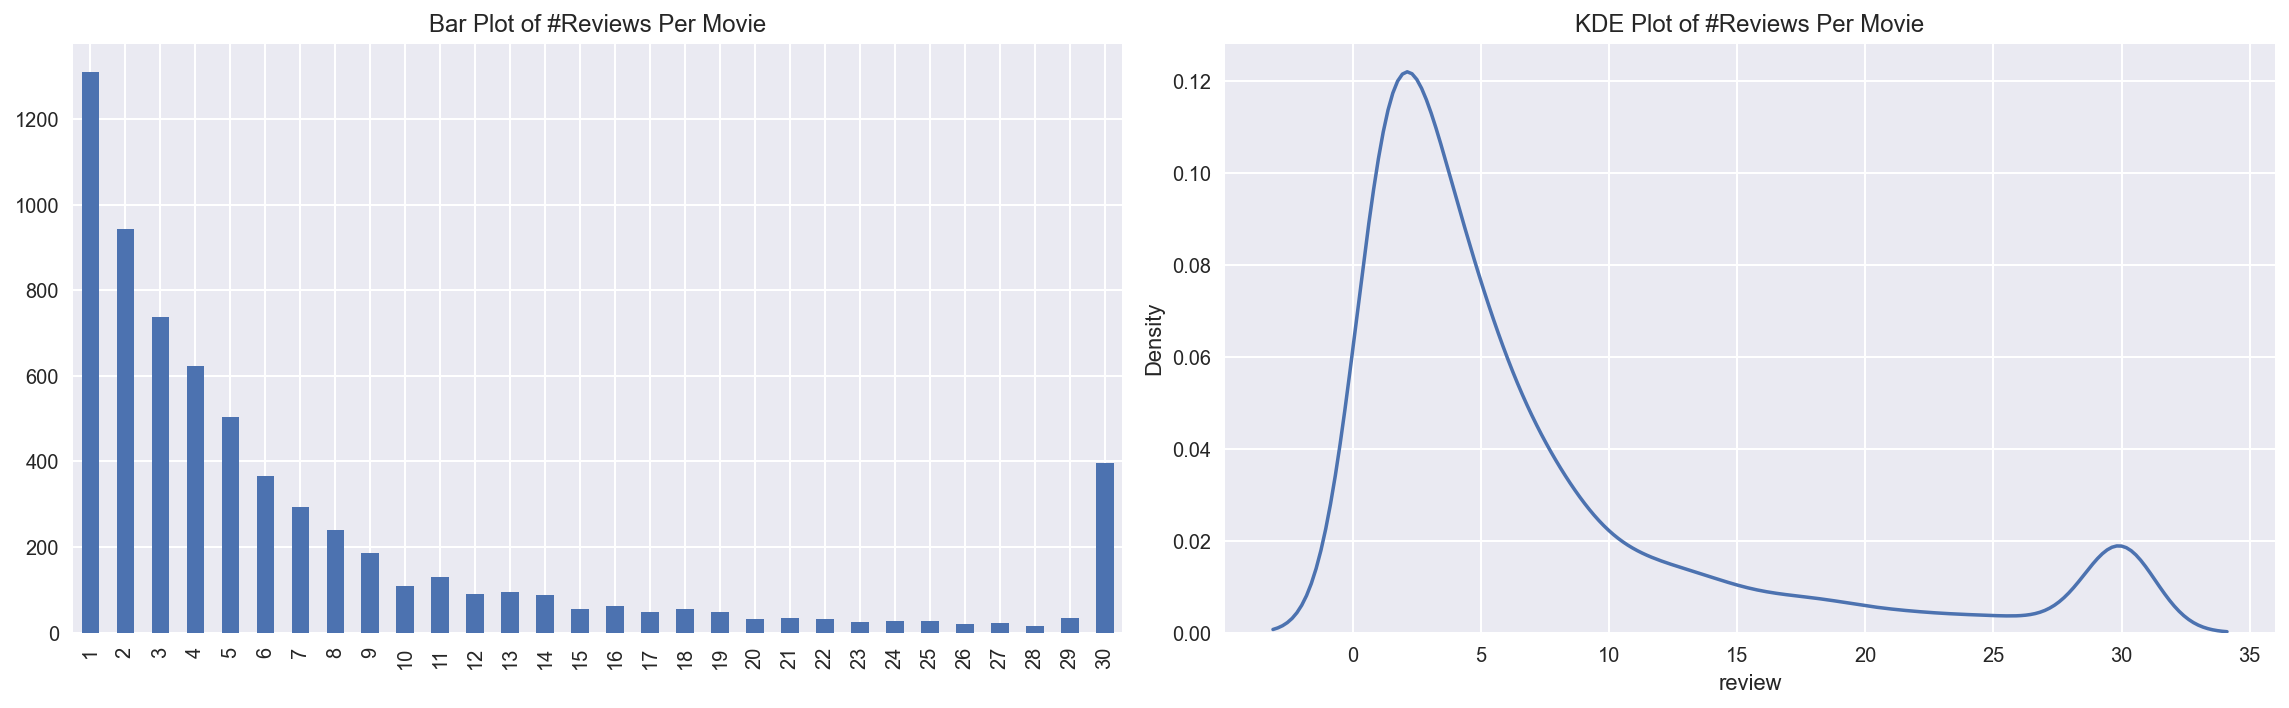

In [268]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

We see the most of the movies have very few reviews, more than 1000 films have just one review.
and than a small jump to 30 reviews to film.

In [269]:
df_reviews['pos'].value_counts()

0    23680
1    23558
Name: pos, dtype: int64

The pos classes are quite equal.

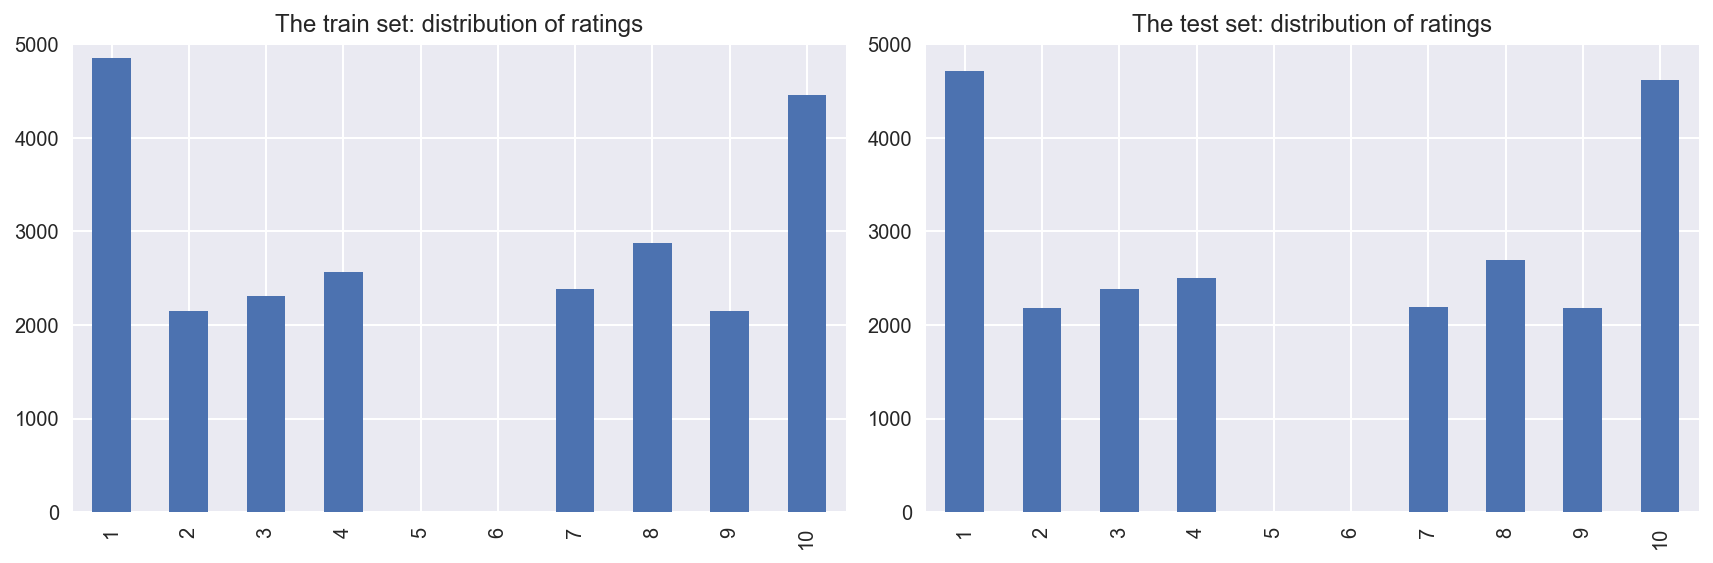

In [270]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

From this plot we can see the distribution of rating is close to the same, meaning our train and test are similar and we can expect our model to preform similarly

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\itay8\anaconda3\lib\site-packages\seaborn\distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\itay8\anaconda3\lib\site-packages\seaborn\distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\itay8\anaconda3\lib\site-packages\seaborn\distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\itay8\anaconda3\lib\site-packages\seaborn\distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


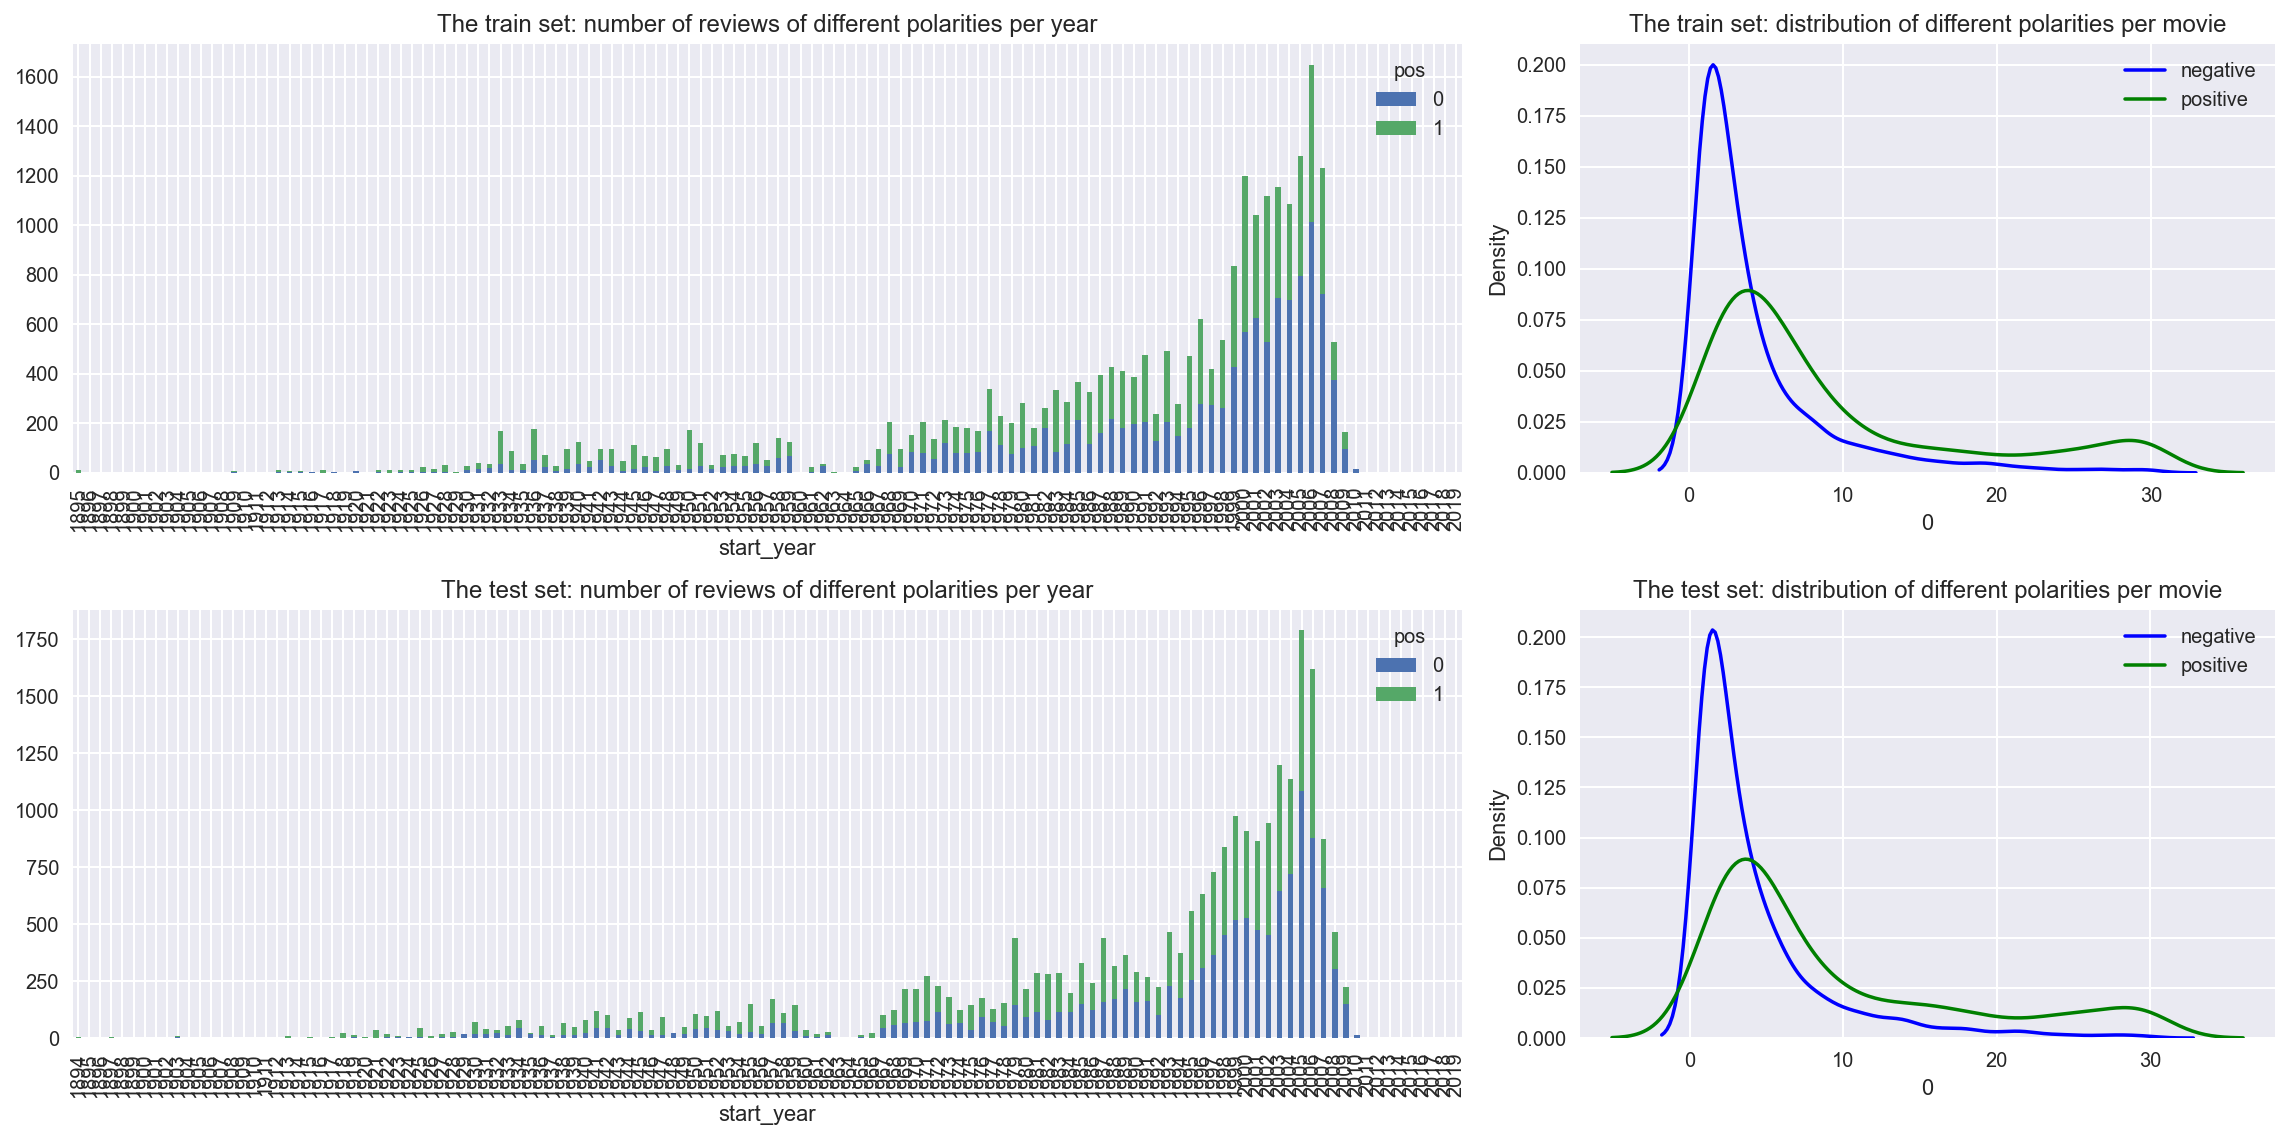

In [271]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [272]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [273]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text).lower()
    return " ".join(text.split())

In [274]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: clear_text(x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [192]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']


X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']



print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [193]:
from sklearn.dummy import DummyClassifier

In [194]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

          train  test
Accuracy   0.49  0.49
F1         0.49  0.49
APS        0.50  0.50
ROC AUC    0.50  0.51


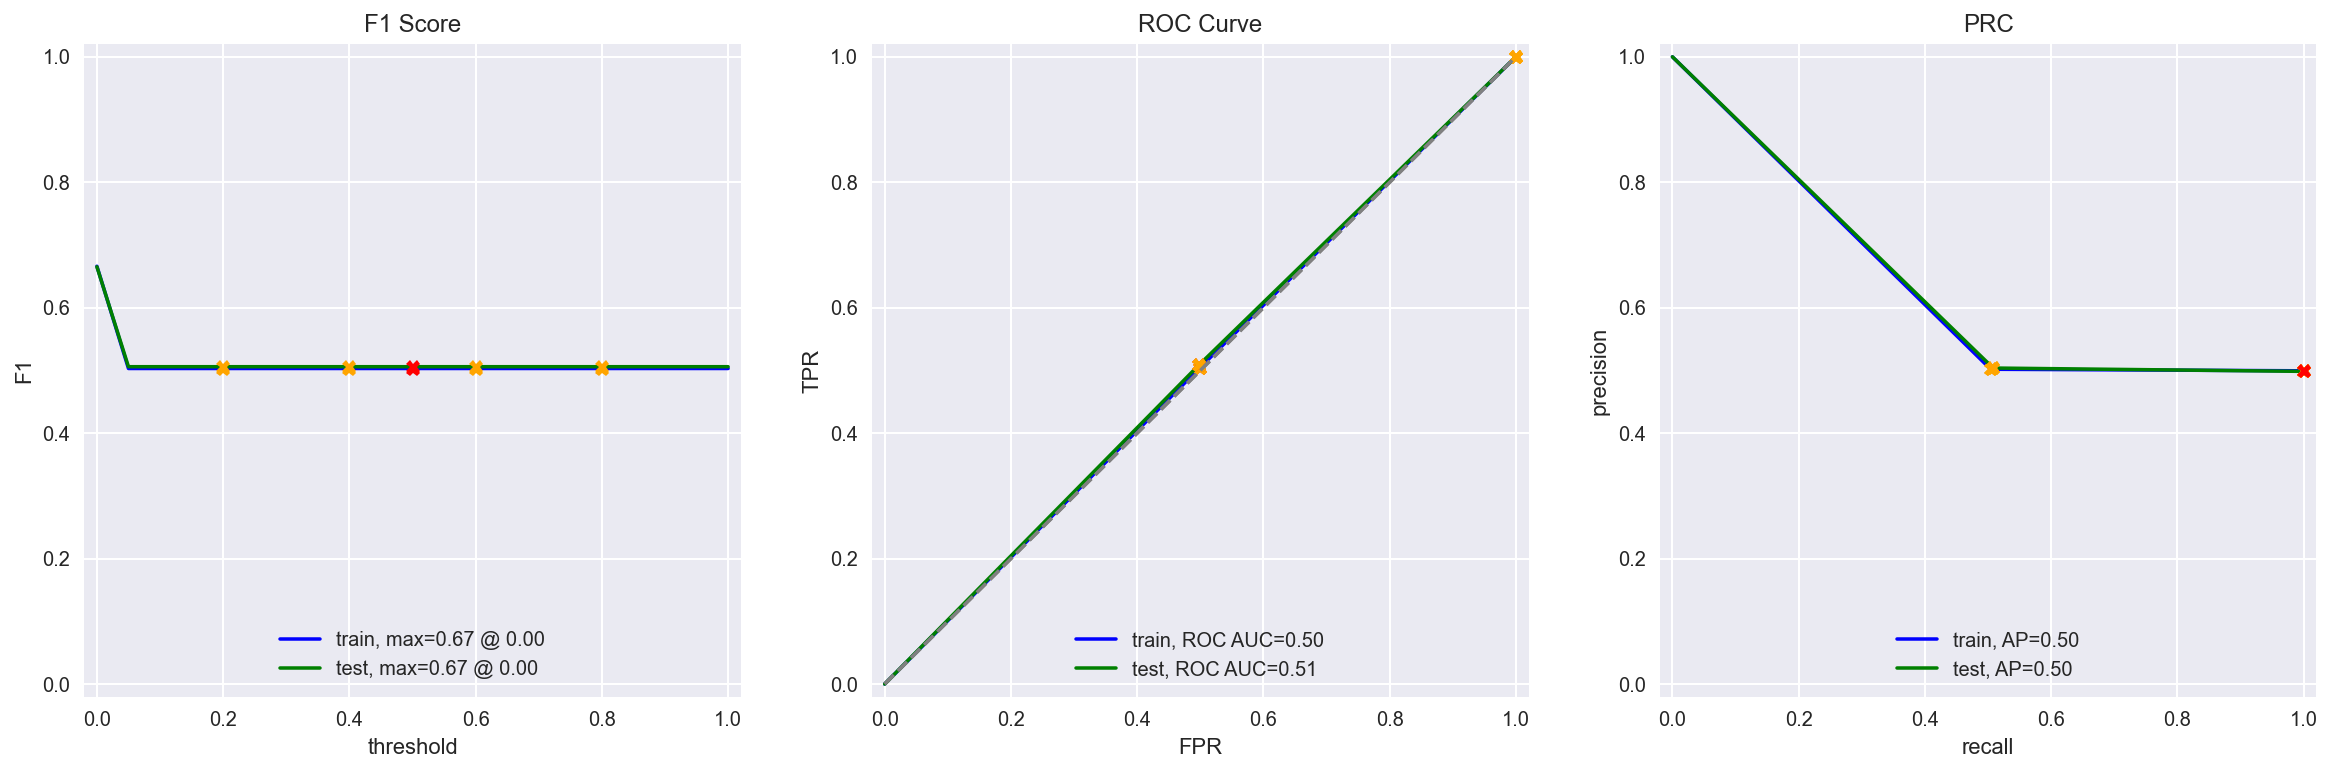

In [195]:
evaluate_model(dummy_clf, X_train, y_train, X_test, y_test)

As expected no better than a coin toss.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [196]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [197]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itay8\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [198]:

stop_words = set(stopwords.words('english'))

In [206]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

In [207]:
X_train_1 = tfidf_vectorizer_1.fit_transform(X_train)

In [208]:
X_test_1 = tfidf_vectorizer_1.transform(X_test)

In [209]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear').fit(X_train_1, y_train)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


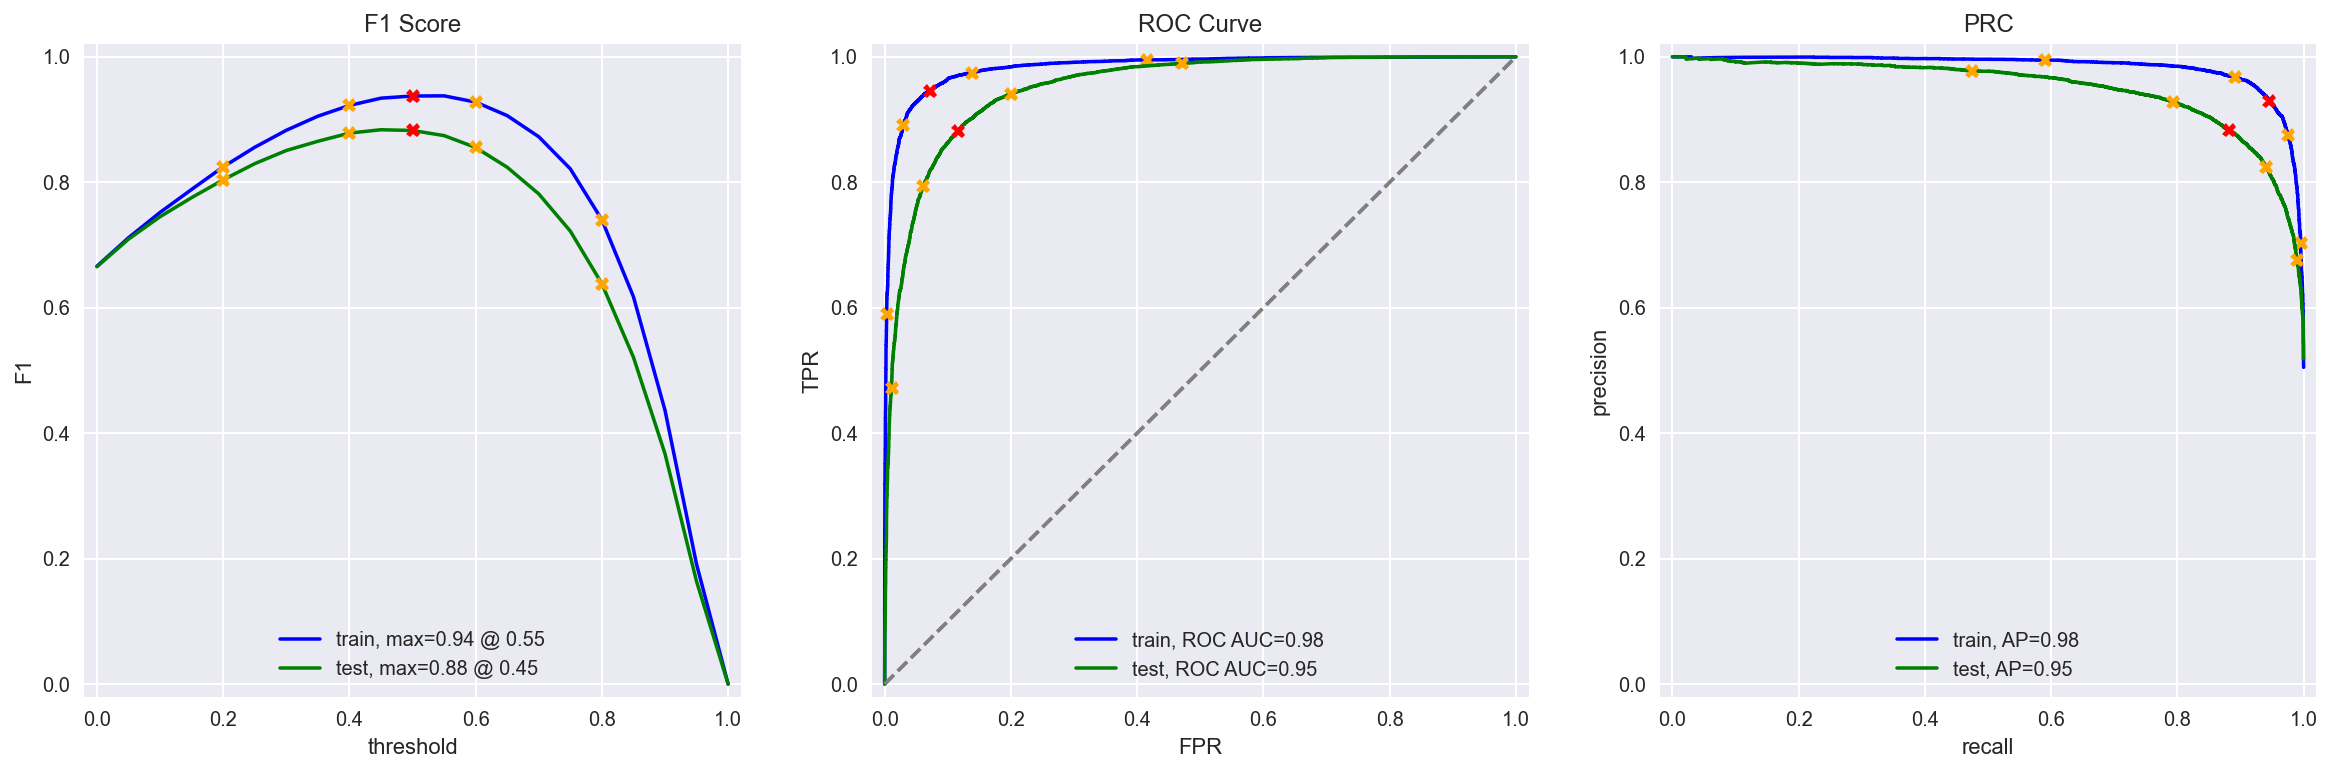

In [210]:
evaluate_model(model_1, X_train_1, y_train, X_test_1, y_test) 

### Model 3 - spaCy, TF-IDF and LR

In [211]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [212]:
def text_preprocessing_3(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [213]:
X_train_2 = X_train.apply(text_preprocessing_3)

In [214]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
X_train_2 = count_tf_idf.fit_transform(X_train_2)

In [215]:
X_test_2 = X_test.apply(text_preprocessing_3)

In [216]:
X_test_2 = count_tf_idf.transform(X_test_2)

In [217]:
model_2 = LogisticRegression(random_state=12345).fit(X_train_2, y_train)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


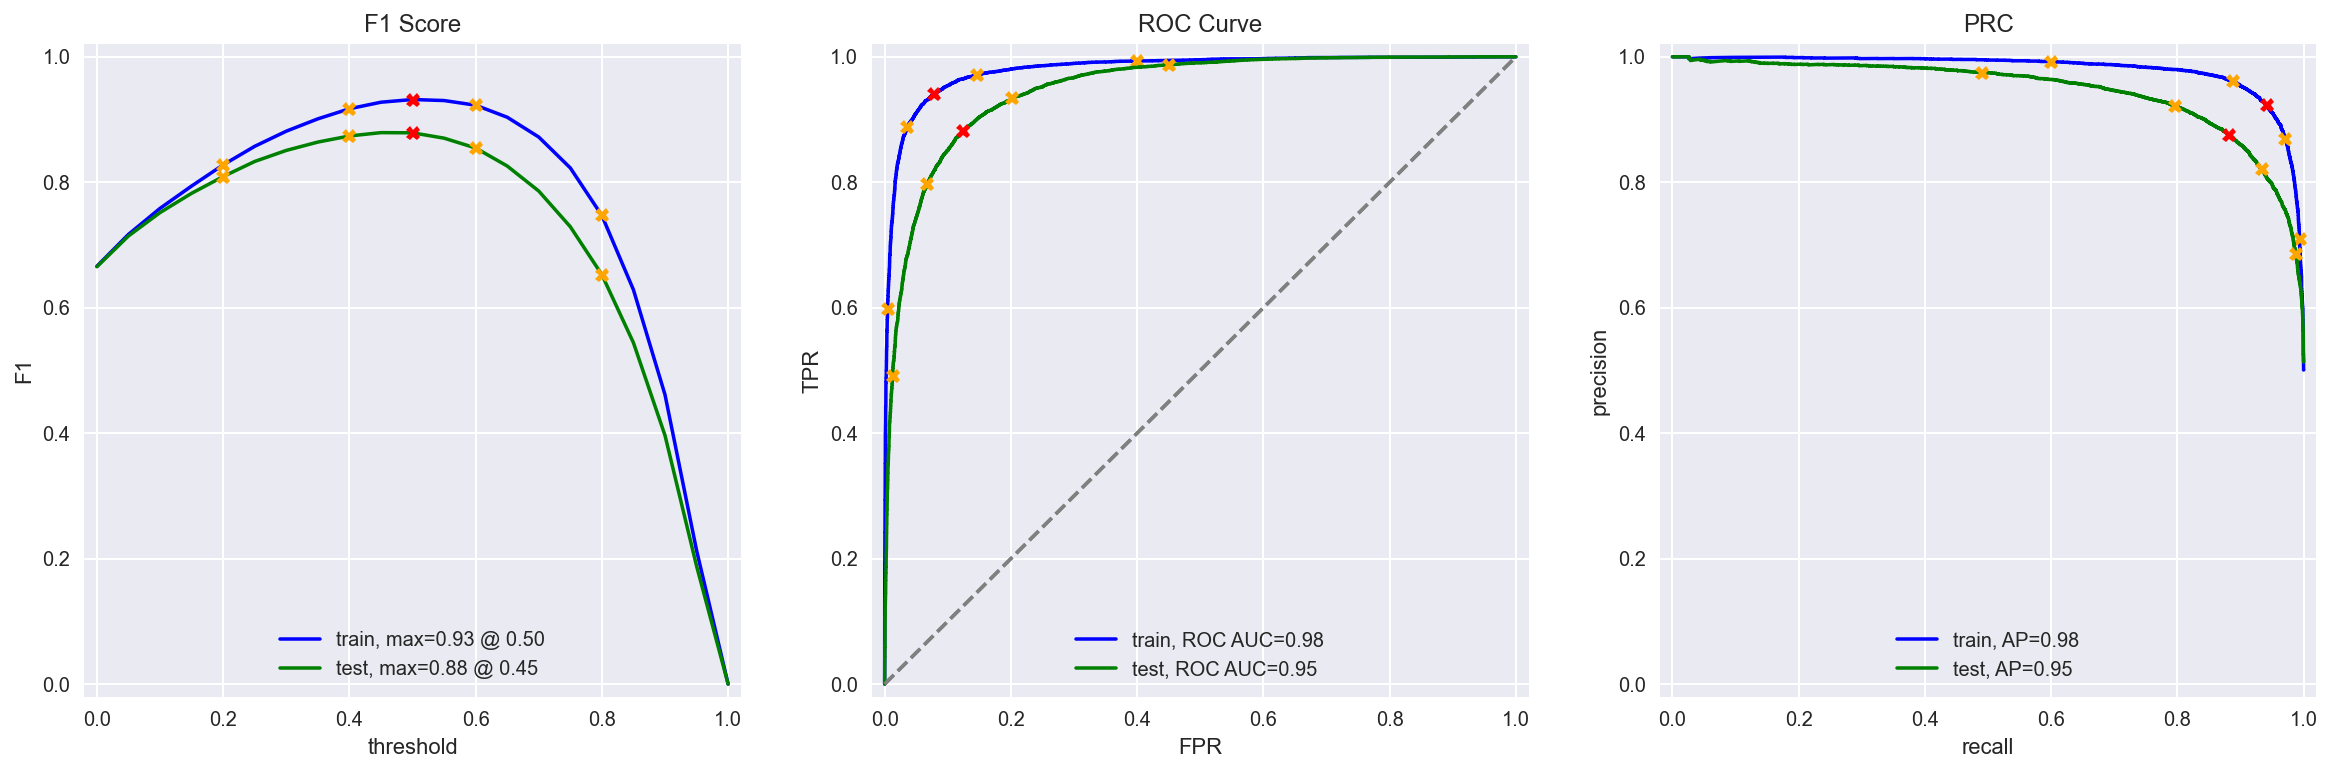

In [218]:
evaluate_model(model_2, X_train_2, y_train, X_test_2, y_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [219]:
from lightgbm import LGBMClassifier

In [220]:
model_3 = LGBMClassifier(n_estimators=200)
model_3.fit(X_train_2, y_train)

LGBMClassifier(n_estimators=200)

          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


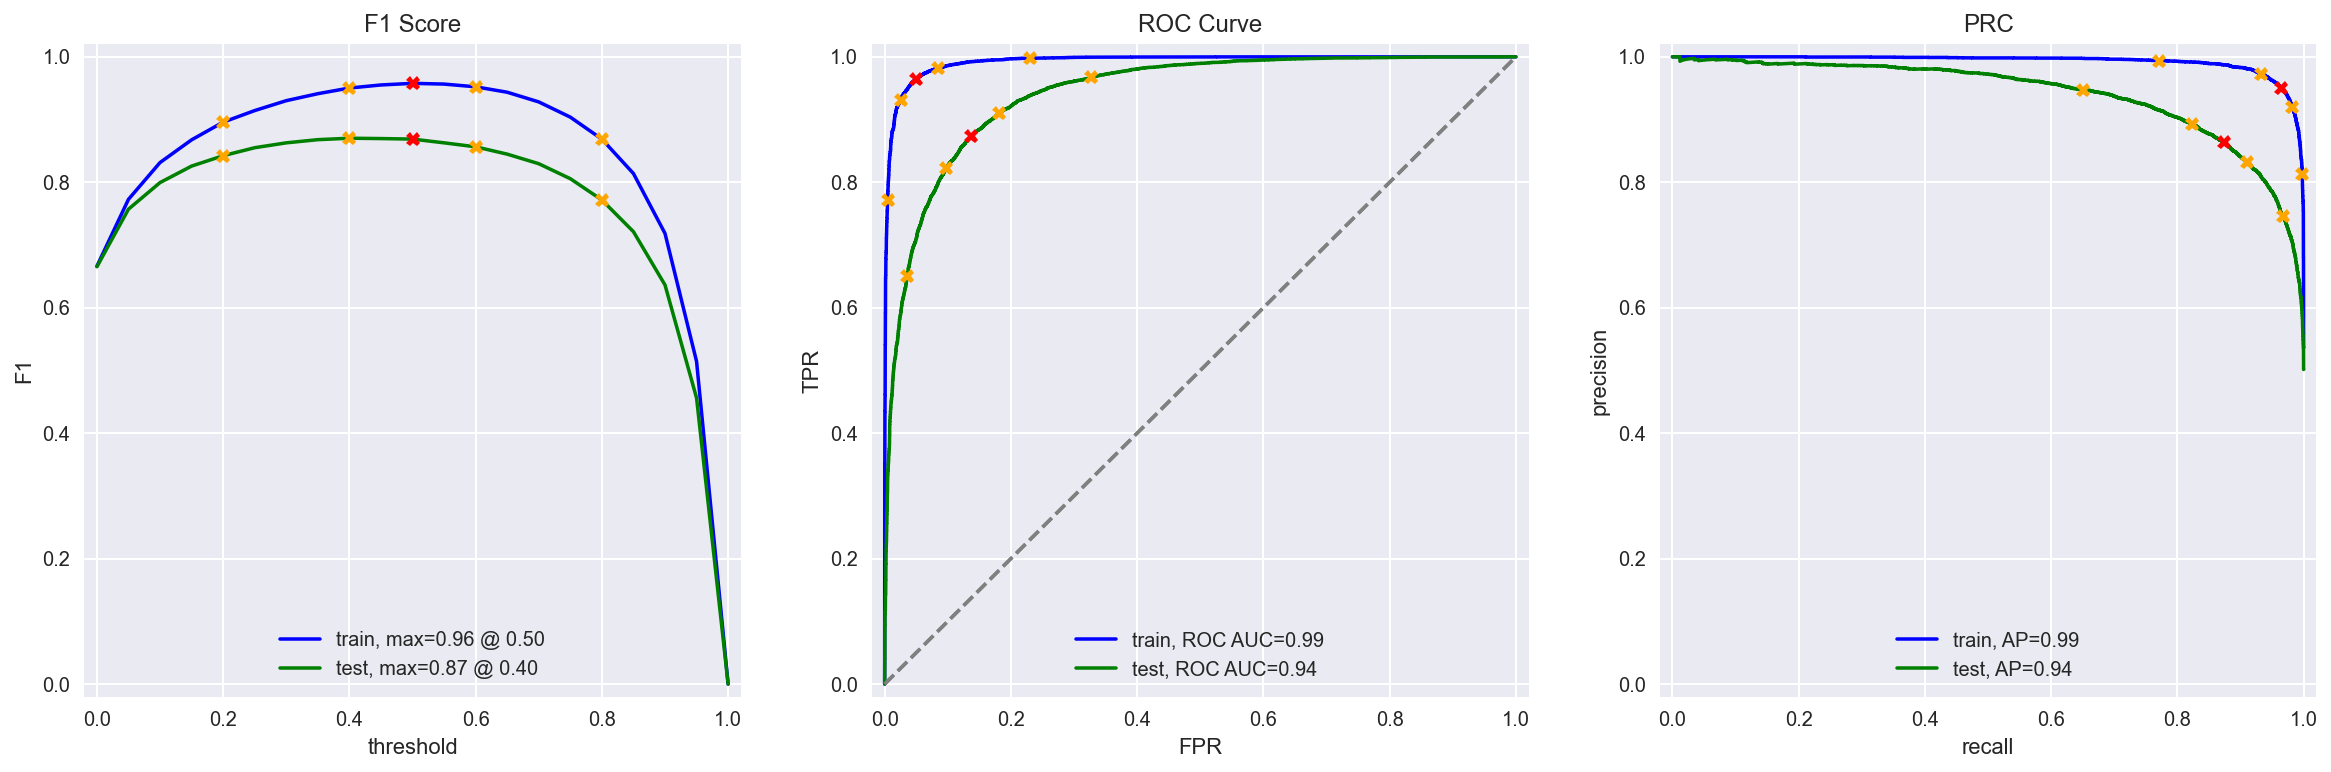

In [222]:
evaluate_model(model_3, X_train_2, y_train, X_test_2, y_test)

With default setting, our model prefomed the worse only after setting n_estimators to 200 did we get our 87%. 

In [245]:

df_reviews_train = df_reviews.query('ds_part == "train"').copy().sample(1000)
df_reviews_test = df_reviews.query('ds_part == "test"').copy().sample(1000)


X_train_3 = df_reviews_train.review_norm
y_train_3 = df_reviews_train.pos


X_test_3 = df_reviews_test.review_norm
y_test_3 = df_reviews_test.pos



print(X_train_3.shape)
print(X_test_3.shape)

(1000,)
(1000,)


###  Model 9 - BERT

In [226]:
import torch
import transformers

In [235]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [229]:
# the BERT model creates embeddings in batches. Make the batch size small so that the RAM won't be overwhelmed:
# changed from batch_size=100 to batch_size=25
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False): 
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
        
    # <put your code here to create ids_list and attention_mask_list>
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    #if force_device is not None:
    #    device = torch.device(force_device)
    #else:
    #    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    device = torch.device(force_device if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using the {device} device.')
    model.to(device)
    
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [246]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(X_train_3, force_device='cuda')


  0%|          | 0/40 [00:00<?, ?it/s]

Using the cpu device.
Using the cpu device.


100%|██████████| 40/40 [08:37<00:00, 12.93s/it]


In [247]:
test_features_9 = BERT_text_to_embeddings(X_test_3, force_device='cuda')

  0%|          | 0/40 [00:00<?, ?it/s]

Using the cpu device.
Using the cpu device.


100%|██████████| 40/40 [08:36<00:00, 12.91s/it]


In [248]:
print(X_train_3.shape)
print(train_features_9.shape)
print(X_train.shape)

(1000,)
(1000, 768)
(23796,)


In [249]:
model_9 = LogisticRegression(random_state=12345, solver='liblinear') 

In [250]:
model_9.fit(train_features_9, y_train_3)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.97  0.82
F1         0.97  0.81
APS        1.00  0.90
ROC AUC    1.00  0.90


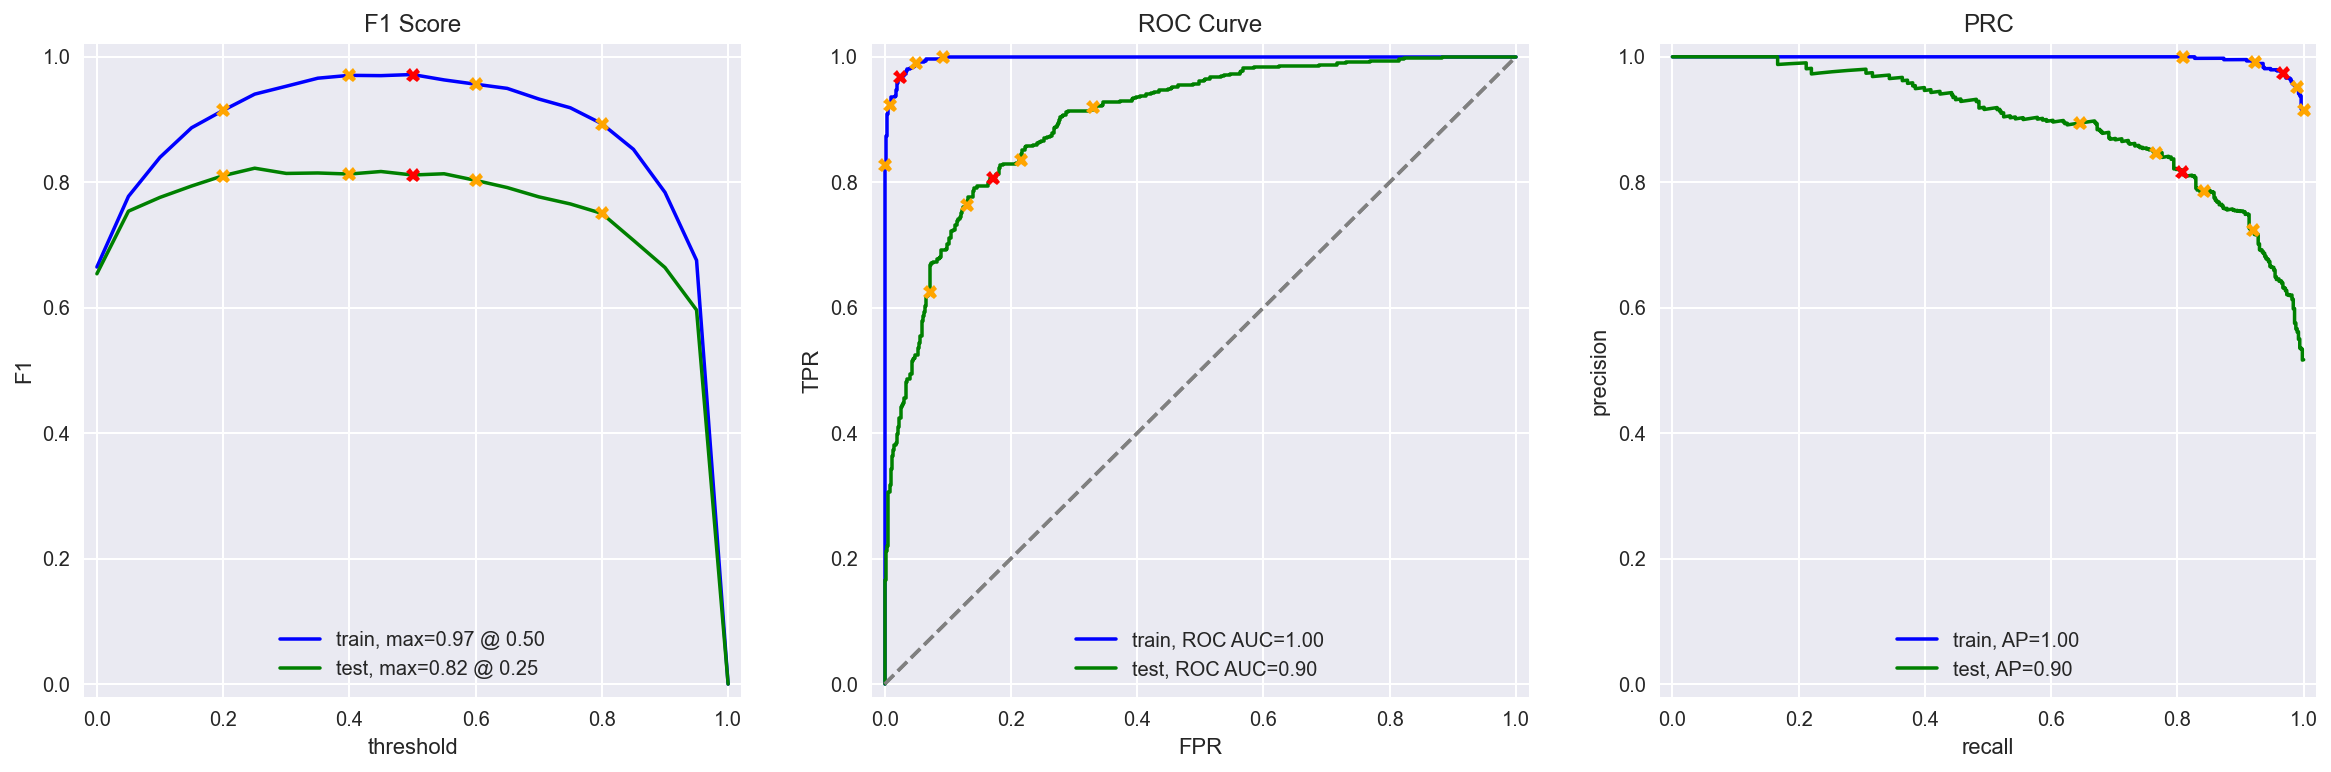

In [251]:
evaluate_model(model_9, train_features_9, y_train_3, test_features_9, y_test_3)

Even with 1000 model was not able to reach the goal.

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = # <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

* Logistic regression using nltk and spacy did very well.
* Bert preformed the worse but the data was limited.
* Timewise, Bert was the slowest 


# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions